<a href="https://colab.research.google.com/github/maticvl/dataHacker/blob/master/NN/NN_TF_ShallowNN_Circles_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shallow layer neural network with Tensorflow

## 0. Import the required libraries:
We will start with importing the required Python libraries.

In [0]:
# Numerical computing
from scipy.stats import kde
import tensorflow as tf
import numpy as np

# Visualization
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import clim
%matplotlib inline


import seaborn as sns
sns.set(style="darkgrid")

# Importing our dataset
from sklearn.datasets import make_circles

## 1. Create some artificial dataset

random data

In [0]:
X, y = make_circles(n_samples = 3000, noise = 0.08, factor=0.3)

Spliting our data into train and test sets and seperating those features that belongs to either label 1 or 0


In [0]:
X0 = [X[i,:] for i in range(len(y)) if y[i] == 0] # returns the row were the corresponding label is 0
X1 = [X[i,:] for i in range(len(y)) if y[i] == 1] # returns the row were the corresponding label is 1

X0_np = np.array(X0) # convert it into an array
X1_np = np.array(X1) 

X0_train = X0_np[:1000,:].T 
X0_test = X0_np[1000:,:].T 

X1_train = X1_np[:1000,:].T  
X1_test = X1_np[1000:,:].T 

X_train = np.hstack([X0_train,X1_train]).T # all training examples
y_train=np.zeros((1,2000))
y_train[0, 1000:] = 1

X_test = np.hstack([X0_test,X1_test]).T # all test examples
y_test=np.zeros((1,1000))
y_test[0, 500:] = 1

Visualization

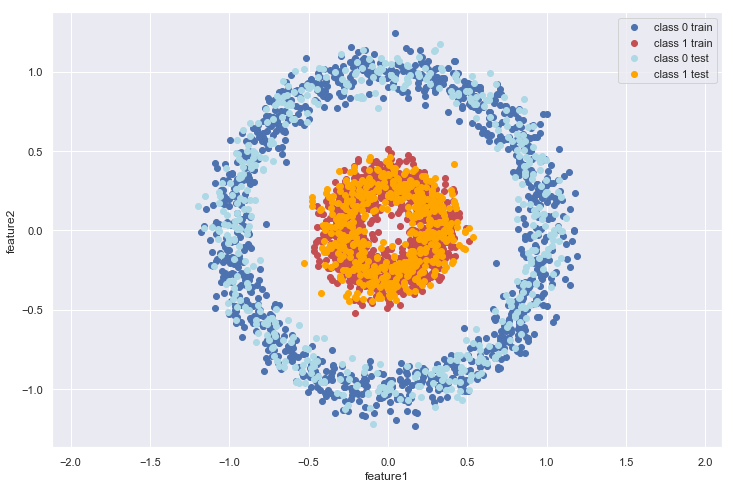

In [0]:
plt.figure(figsize=(12,8))
plt.scatter(X0_train[0,:],X0_train[1,:], color = 'b', label = 'class 0 train')
plt.scatter(X1_train[0,:],X1_train[1,:], color = 'r',  label = 'class 1 train')
plt.scatter(X0_test[0,:],X0_test[1,:], color = 'LightBlue', label = 'class 0 test')
plt.scatter(X1_test[0,:],X1_test[1,:], color = 'Orange', label = 'class 1 test')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.axis("equal")
plt.legend()

Now we should reshape your labels as 2d-tensor (the first dimension will be the batch dimension and the second the scalar label)

In [0]:
# Reshape our label to avoid having a rank-1 array (n,)
# Don't use rank-1 arrays when implement logistic regression, instead use a rank-2 arrays (n, 1)
# We are also making sure our datatypes are converted into float32.

# Our vectorized labels
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

Now we need to get a feel of the size of our dataset

In [0]:
print('x_train:\t{}'.format(X_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(X_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(2000, 2)
y_train:	(2000, 1)
x_test:		(1000, 2)
y_test:		(1000, 1)


## 2. Hyperparameters

Hyperparameters are model-specific properties that are fixed before you even train and test your model on data.

In [0]:
# Hyper-parameters
training_epochs = 400 # Total number of training epochs
learning_rate = 0.03 # The learning rate

## 3. Designing our neural network

Now we are defining how many layers we have in our network along with its hidden units

In [0]:
n_input_unit = X_train.shape[1]
n_hidden_unit_1 = 4
n_output_unit = y_train.shape[1]
                              
print("Input layer: {} visible units".format(n_input_unit))
print("First layer: {} hidden units".format(n_hidden_unit_1))
print("Output layer: {} output unit ".format(n_output_unit))

Input layer: 2 visible units
First layer: 4 hidden units
Output layer: 1 output unit 


## 4. Create the network graph
After defining all our hyperparameters we can now create our network

### 4.1. Placeholders for the inputs (data) and corresponding labels (targets)

Placeholder is an object whose value can be specified only later. To specify values for a placeholder, we need to pass in values by using a "feed dictionary"

In [0]:
dimension_of_features = X_train.shape[1]
dimension_of_classes = y_train.shape[1]

print("Dimension of our features : {}".format(dimension_of_features))
print("Dimension of our class : {}".format(dimension_of_classes))

Dimension of our features : 2
Dimension of our class : 1


In [0]:
# Placeholders for inputs (data) and outputs(target)

data = tf.placeholder(dtype=tf.float32, shape=[None, dimension_of_features], name='data')

target = tf.placeholder(dtype=tf.float32, shape=[None, dimension_of_classes], name='targets')

### 4.2. Initialize our paramaters

Initializing our weights and biases with random values * 0.01



In [0]:
weights = {
    'w1' : tf.Variable(tf.random_normal([n_input_unit, n_hidden_unit_1]) * 0.01),
    'w2' : tf.Variable(tf.random_normal([n_hidden_unit_1, n_output_unit]) * 0.01)
}

# logging our weights 
tf.summary.histogram("Weight_1__",weights["w1"])
tf.summary.histogram("Weight_2__",weights["w2"])

<tf.Tensor 'Weight_2__:0' shape=() dtype=string>

In [0]:
biases = {
  'b1' : tf.Variable(tf.zeros([n_hidden_unit_1])), 
  'b2' : tf.Variable(tf.zeros([n_output_unit])) 
}

# logging our biases
tf.summary.histogram("Biases_1__", biases["b1"])
tf.summary.histogram("Biases_2__", biases["b2"])

<tf.Tensor 'Biases_2__:0' shape=() dtype=string>

### 4.3 Forward Propagation

In [0]:
def shallowLayerNetwork(X, weights, biases):
    
    # First layer
    layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # output layer. We need to have a linear output instead of a non-linear output
    output_layer = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    
    return output_layer

In [0]:
# Forward-propagation
predictions = shallowLayerNetwork(data, weights, biases)

### 4.4. Define the loss function, optimizer, accuracy, and predicted class

In [0]:
# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=predictions))

# Create a summary to monitor the cost function
tf.summary.scalar("Loss_function",loss)

<tf.Tensor 'Loss_function:0' shape=() dtype=string>

In [0]:
# Back-propagation
# Optimizer { Adam Optimizer : lr=0.03}
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [0]:
# Now we pass our predictions data through a non-linear function (sigmoid) and assign it to a variable called values.
values = tf.sigmoid(predictions)

# compare the results, if the actual values are equal to the predicted values
correct_prediction = tf.equal(target,(tf.to_float(tf.greater(values, 0.5)))) 

# Convert our datatype from boolean into float, and calculate the accuracy of our set of data
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

### 4.5. Initialize all variables
Here, we have to invoke a variable initializer operation to initialize all variables.

In [0]:
# Initialize all variables
init = tf.global_variables_initializer()

# Merge all summaries into a single operator
merged_summary_op = tf.summary.merge_all()

## 5. Training Time !!!
After creating the graph, we have run a session to train our model.

In [0]:
with tf.Session() as session:

    # keep track of the loss, weight and bias for plotting
    loss_values = []
    weight_values = []
    bias_value = []

    # run the initialization
    session.run(init)

    # visualize on tensorboard
    # tensorboard --logdir='shallow_neural_net'
    summary_writer = tf.summary.FileWriter('shallow_neural_net', session.graph)

    # training loop
    for epoch in range(training_epochs):

        # feeding data to our network through the placeholders.
        feed_train = {data: X_train, target: y_train}
        feed_test = {data: X_test, target: y_test}

        _ , value, prediction_values= session.run([optimizer, loss, values], feed_dict=feed_train)

        # storing the results of our loss values
        loss_values.append(value)

        # Display logs per 1000 epochs
        if(epoch % 50) == 0:
            print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(value))

    # Write logs for each epoch
    summary_str = session.run(merged_summary_op, feed_train)
    summary_writer.add_summary(summary_str, epoch)

    print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(value))

    _, loss_test, prediction_values_test = session.run([optimizer, loss, values], feed_dict=feed_test)

    # Getting the results from our output layer
    weight_values = session.run(weights)
    bias_values = session.run(biases)

    print("\nOptimization Finished\n")
    print("Train Accuracy: {:.2f}%".format(accuracy.eval(feed_train)*100))
    print("Test Accuracy: {:.2f}%".format(accuracy.eval(feed_test)*100))

Epoch: 0001 loss= 0.693126202
Epoch: 0051 loss= 0.437095582
Epoch: 0101 loss= 0.124291487
Epoch: 0151 loss= 0.027642380
Epoch: 0201 loss= 0.015909942
Epoch: 0251 loss= 0.010897553
Epoch: 0301 loss= 0.007883752
Epoch: 0351 loss= 0.005932244
Epoch: 0400 loss= 0.004646810

Optimization Finished

Train Accuracy: 100.00%
Test Accuracy: 99.90%


### 5.1. Visualizing our cost
Summary of our cost after 400 Epochs

Text(0.5, 0, 'Epochs')

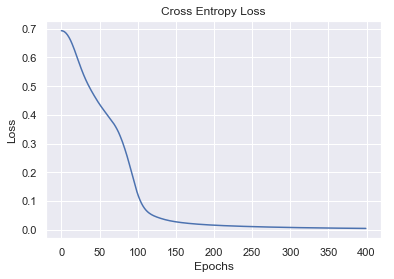

In [0]:
# Ploting our cost
plt.plot(loss_values)
plt.title('Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [0]:
max_loss = np.max(loss_values)
min_loss = np.min(loss_values)
print("Maximum Loss : {:.4f}".format(max_loss))
print("")
print("Minimum Loss : {:.4f}".format(min_loss))
print("")
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

Maximum Loss : 0.6931

Minimum Loss : 0.0046

Loss difference : 0.6885


## 6. Visualization

Models predictions on our test dataset

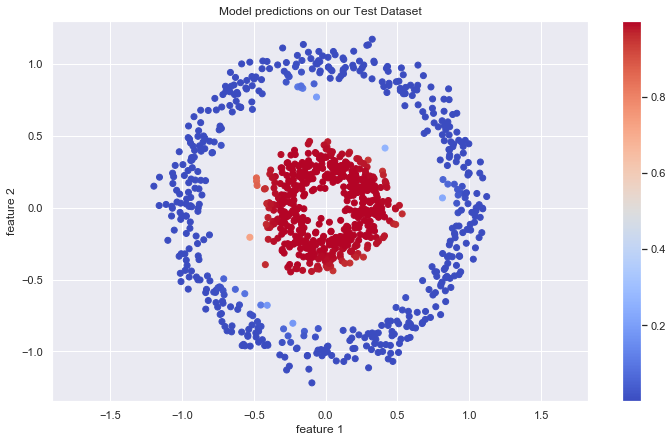

In [0]:
plt.figure(figsize =(12,7))
plt.scatter(X_test[:,0], X_test[:,1], c=prediction_values_test[:, 0], cmap=cm.coolwarm)
plt.title('Model predictions on our Test Dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.axis("equal")
plt.colorbar()

## 7. In depth understanding of a neural network 


First we started by extracting our weight and bias values from the dictionary from each layer in each neuron

In [0]:
w = weight_values

print(weight_values['w1'])
print("\n")

print(weight_values['w2'])
print("\n")

[[ 1.7370971 -4.541667   3.2594516  0.8928923]
 [-4.271985   0.0705593  1.316003   4.5274897]]


[[-4.1525083]
 [-4.6990194]
 [-4.1601076]
 [-3.852351 ]]




In [0]:
b = bias_values

print(bias_values['b1'])
print("\n")

print(bias_values['b2'])
print("\n")

[-0.93051165 -1.0545317  -0.9068997  -1.1831536 ]


[7.223752]




In [0]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))


def relu(z):
    return z * (z > 0)

Now we created some dummy data using np.linspace which returns and evenly spaced numbers over a specified interval

In [0]:
x1 = np.linspace(-2, 2, 50)
x2 = np.linspace(-2,2, 50)
x3 = z = np.linspace(-1,1,50*50);

result = np.zeros((50*50,3)) 

# result from first layer are stored here
out11 = np.zeros((50*50,1))
out12 = np.zeros((50*50, 1))
out13 = np.zeros((50*50, 1))
out14 = np.zeros((50*50, 1))

# result from output layer are stored here
out2 = np.zeros((50*50, 1))

for i in range(len(x1)):
  
  for j in range(len(x2 )):
   
    
    # We took each layer and multiplied them by the weight values, input values and added the bias connected to each one of them
    # Neurons for the first layer (4)
    z_1_1 = x1[i] * w['w1'][0][0] + x2[j] * w['w1'][1][0] + b['b1'][0]
    a_1_1 = relu(z_1_1)

    z_1_2 = x1[i] * w['w1'][0][1] + x2[j] * w['w1'][1][1] + b['b1'][1]
    a_1_2 = relu(z_1_2)

    z_1_3 = x1[i] * w['w1'][0][2] + x2[j] * w['w1'][1][2] + b['b1'][2]
    a_1_3 = relu(z_1_3)

    z_1_4 = x1[i] * w['w1'][0][3] + x2[j] * w['w1'][1][3] + b['b1'][3]
    a_1_4 = relu(z_1_4)


    # Neuron for the last layer (1)
    z_2 = a_1_1 * w['w2'][0][0] + a_1_2 * w['w2'][1][0] + a_1_3 * w['w2'][2][0] + a_1_4 * w['w2'][3][0] + b['b2'][0]
    a_2 = sigmoid(z_2)

    # This is our dummy dataset
    result[i*50+j,0 ] = x1[i]
    result[i*50+j, 1] = x2[j]

    # Assigning the output of each layer to an output variable
    out11[i*50+j] = a_1_1
    out12[i*50+j] = a_1_2
    out13[i*50+j] = a_1_3
    out14[i*50+j] = a_1_4

    out2[i*50+j] = a_2

### What happens on the first hidden layer for each neurons

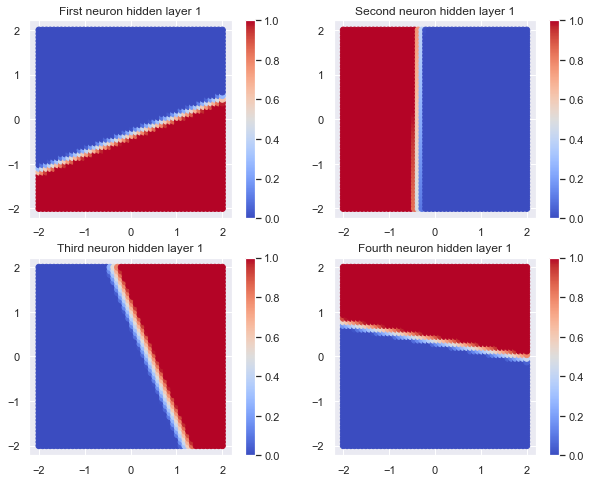

In [0]:
plt.figure(figsize =(10,8))

# First neuron, layer 1
plt.subplot(221)
plt.title('First neuron hidden layer 1')
plt.scatter(result[:, 0], result[:, 1], c= out11.reshape(-1), cmap=cm.coolwarm)
plt.colorbar()
plt.clim(0, 1)

# Second neuron, layer 1
plt.subplot(222)
plt.title('Second neuron hidden layer 1')
plt.scatter(result[:, 0], result[:, 1], c= out12.reshape(-1), cmap=cm.coolwarm)
plt.colorbar()
plt.clim(0, 1)

# Third neuron, layer 1
plt.subplot(223)
plt.title('Third neuron hidden layer 1')
plt.scatter(result[:, 0], result[:, 1], c= out13.reshape(-1), cmap=cm.coolwarm)
plt.colorbar()
plt.clim(0, 1)

# Fourth neuron, layer 1
plt.subplot(224)
plt.title('Fourth neuron hidden layer 1')
plt.scatter(result[:, 0], result[:, 1], c= out14.reshape(-1), cmap=cm.coolwarm)
plt.colorbar()
plt.clim(0, 1)

First Neuron in the hidden layer

Text(0.5, 0.92, '3D visualization of our neural network output layer')

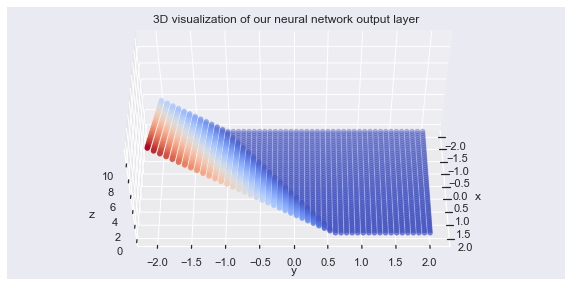

In [0]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
bar = ax.scatter3D(xs=result[:, 0], ys=result[:, 1], zs=out11.reshape(-1), c= out11.reshape(-1), cmap=cm.coolwarm);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# we use view_init in changing the viewing angle
ax.view_init(50, 0)

ax.set_title('3D visualization of our neural network output layer')

Second Neuron in the hidden layer

Text(0.5, 0.92, '3D visualization of our neural network output layer')

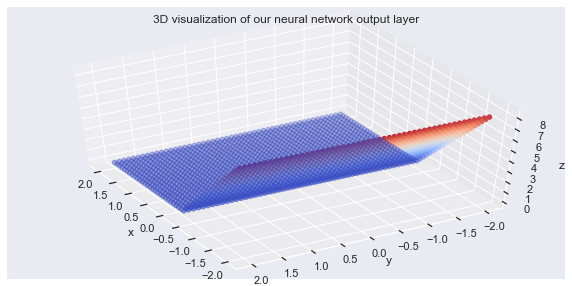

In [0]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
bar2 = ax.scatter3D(xs=result[:, 0], ys=result[:, 1], zs=out12.reshape(-1), c= out12.reshape(-1), cmap=cm.coolwarm);

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# we use view_init in changing the viewing angle
ax.view_init(50, 150)

ax.set_title('3D visualization of our neural network output layer')

Third Neuron in the hidden layer

Text(0.5, 0.92, '3D visualization of our neural network output layer')

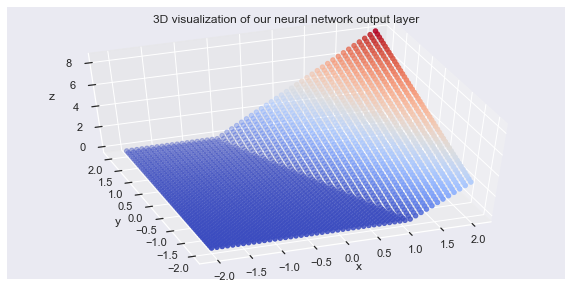

In [0]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
bar3 = ax.scatter3D(xs=result[:, 0], ys=result[:, 1], zs=out13.reshape(-1), c= out13.reshape(-1), cmap=cm.coolwarm);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# we use view_init in changing the viewing angle
ax.view_init(50, 250)

ax.set_title('3D visualization of our neural network output layer')

Fourth Neuron in the hidden layer

Text(0.5, 0.92, '3D visualization of our neural network output layer')

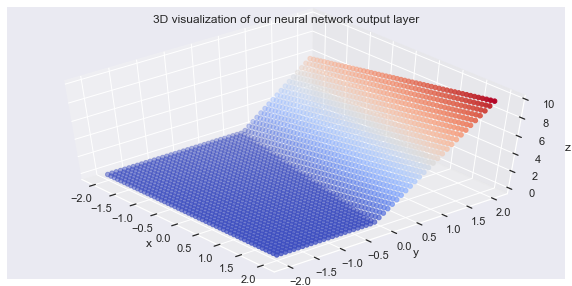

In [0]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
bar4 = ax.scatter3D(xs=result[:, 0], ys=result[:, 1], zs=out14.reshape(-1), c= out14.reshape(-1), cmap=cm.coolwarm);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# we use view_init in changing the viewing angle
ax.view_init(50, 320)

ax.set_title('3D visualization of our neural network output layer')

Then on the final layer, which is the output layer

(-2.208448540706605,
 2.2084485407066055,
 -2.2086723431094293,
 2.208672343109429)

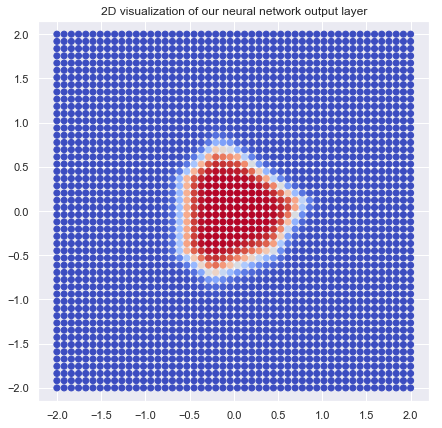

In [0]:
plt.figure(figsize =(7,7))

# output layer
plt.subplot(111)
plt.title('2D visualization of our neural network output layer')
plt.scatter(result[:, 0], result[:, 1], c= out2.reshape(-1), cmap=cm.coolwarm)
plt.axis("equal")

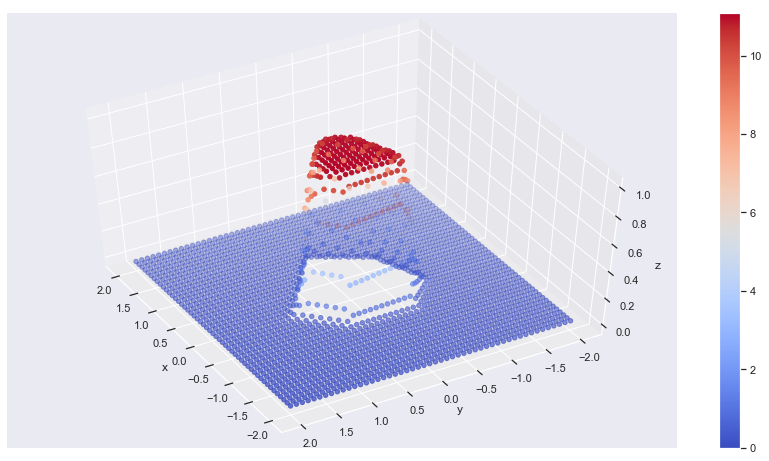

In [0]:
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection='3d')
bar5 = ax.scatter3D(xs=result[:, 0], ys=result[:, 1], zs=out2.reshape(-1), c= out2.reshape(-1), cmap=cm.coolwarm);

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# we use view_init in changing the viewing angle
ax.view_init(50, 150)

plt.colorbar(bar)

In [0]:
def f(x, y):
    return np.sqrt(x ** 2 + y ** 2)

x = result[:, 0]
y = result[:, 1]

X, Y = np.meshgrid(x, y) 
Z = f(X, Y)

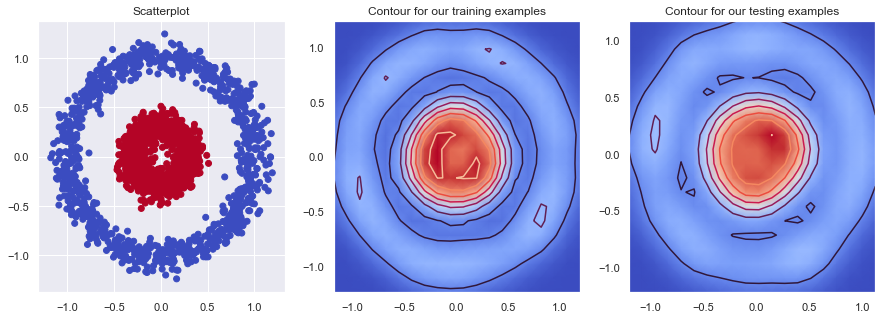

In [0]:
# Create a figure with 2 plot areas
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
 
# Everything sarts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].scatter(X_train[:, 0], X_train[: ,1], c=y_train.reshape(-1),  cmap=cm.coolwarm) 
nbins = 20
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents (Training examples)
k_train = kde.gaussian_kde(X_train.T)
xi_train, yi_train = np.mgrid[X_train[:, 0].min():X_train[:, 0].max():nbins*1j, X_train[:, 1].min():X_train[:, 1].max():nbins*1j]
zi_train = k_train(np.vstack([xi_train.flatten(), yi_train.flatten()]))

# Contour for training examples
axes[1].set_title('Contour for our training examples')
axes[1].pcolormesh(xi_train, yi_train, zi_train.reshape(xi_train.shape), shading='gouraud', cmap=cm.coolwarm)
axes[1].contour(xi_train, yi_train, zi_train.reshape(xi_train.shape) )


# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents (Test examples)
k_test = kde.gaussian_kde(X_test.T)
xi_test, yi_test = np.mgrid[X_test[:, 0].min():X_test[:, 0].max():nbins*1j, X_test[:, 1].min():X_test[:, 1].max():nbins*1j]
zi_test = k_test(np.vstack([xi_test.flatten(), yi_test.flatten()]))

# Contour for our testing examples
axes[2].set_title('Contour for our testing examples')
axes[2].pcolormesh(xi_test, yi_test, zi_test.reshape(xi_test.shape), shading='gouraud', cmap=cm.coolwarm)
axes[2].contour(xi_test, yi_test, zi_test.reshape(xi_test.shape) )

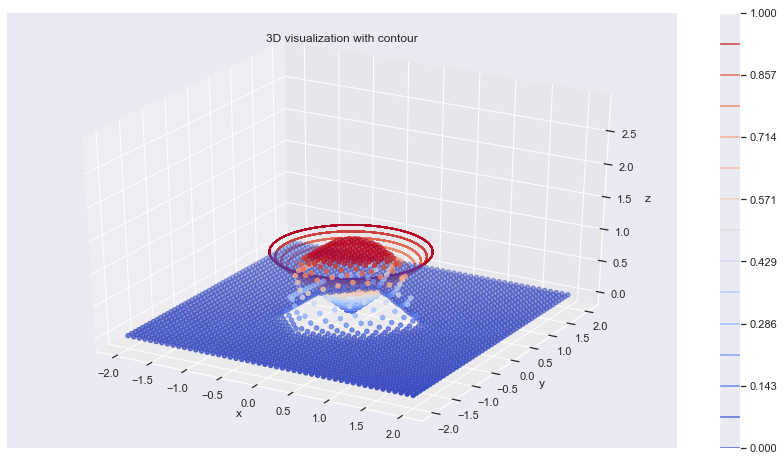

In [0]:
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection='3d')

bar5 = ax.scatter3D(xs=result[:, 0], ys=result[:, 1], zs=out2.reshape(-1), c= out2.reshape(-1), cmap=cm.coolwarm);

levels = np.linspace(0, 1, 15)
contour = ax.contour3D(X, Y, Z, levels, cmap=cm.coolwarm, linestyles="solid") # The Z must be a 2d shape

ax.set_xlabel('x') 
ax.set_ylabel('y')
ax.set_zlabel('z');

ax.set_title('3D visualization with contour')
plt.colorbar(contour)